# Load Data

In [1]:
%matplotlib inline

In [2]:
import re
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer

In [3]:
train_data = pd.read_csv('Train.csv', sep=',')
test_data = pd.read_csv('Test.csv', sep=',')
valid_data = pd.read_csv('Valid.csv', sep=',')

# Preprocessing

In [4]:
def split(data):
    html_pat = re.compile('<.*?>')
    punctuation_pat = re.compile('["?!#$%&\'()*+,-./:;<=>@[\\]^_`{|}~ ]')
    
    sentences = []
    
    for i, text in enumerate(data['text']):
        filtered_text = html_pat.sub('', text)
        words = list(filter(lambda x:x!='', punctuation_pat.split(filtered_text)))
        sentences.append(words)
        
    return sentences

In [5]:
train = split(train_data)
test = split(test_data)
valid = split(valid_data)

In [6]:
print(train[0])

['I', 'grew', 'up', 'b', '1965', 'watching', 'and', 'loving', 'the', 'Thunderbirds', 'All', 'my', 'mates', 'at', 'school', 'watched', 'We', 'played', 'Thunderbirds', 'before', 'school', 'during', 'lunch', 'and', 'after', 'school', 'We', 'all', 'wanted', 'to', 'be', 'Virgil', 'or', 'Scott', 'No', 'one', 'wanted', 'to', 'be', 'Alan', 'Counting', 'down', 'from', '5', 'became', 'an', 'art', 'form', 'I', 'took', 'my', 'children', 'to', 'see', 'the', 'movie', 'hoping', 'they', 'would', 'get', 'a', 'glimpse', 'of', 'what', 'I', 'loved', 'as', 'a', 'child', 'How', 'bitterly', 'disappointing', 'The', 'only', 'high', 'point', 'was', 'the', 'snappy', 'theme', 'tune', 'Not', 'that', 'it', 'could', 'compare', 'with', 'the', 'original', 'score', 'of', 'the', 'Thunderbirds', 'Thankfully', 'early', 'Saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'of', 'the', 'series', 'Gerry', 'Anderson', 'and', 'his', 'wife', 'created', 'Jonatha', 'Frakes', 'should', 'hand', 'in', 

In [7]:
def sentence_length(sentence):
    return list(map(lambda x:len(x), sentence))

(0.0, 1000.0)

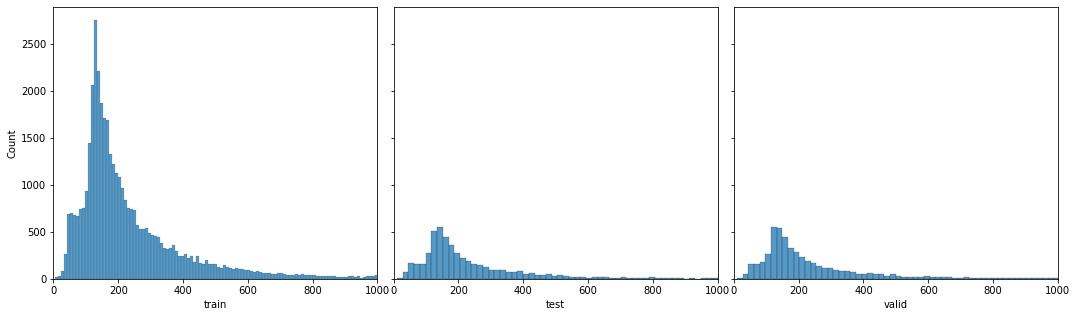

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=True, sharey=True)
data=pd.DataFrame(sentence_length(train), columns=['train'], )
sns.histplot(data=data, x='train', ax=axes[0])

data=pd.DataFrame(sentence_length(test), columns=['test'])
sns.histplot(data=data, x='test', ax=axes[1])

data=pd.DataFrame(sentence_length(valid), columns=['valid'])
sns.histplot(data=data, x='valid', ax=axes[2])

plt.subplots_adjust(wspace=0.05)
plt.xlim(0,1000)

In [9]:
def align(sentence, length):
    if len(sentence) < length:
        return sentence + ['<PAD>' for x in range(length - len(sentence))]
    else:
        return sentence[:length]

In [10]:
train = list(map(lambda x: align(x, 250), train))
test = list(map(lambda x: align(x, 250), test))
valid = list(map(lambda x: align(x, 250), valid))

In [11]:
stemmer = SnowballStemmer('english')

def stemming(sentence, stemmer):
    return [stemmer.stem(word) for word in sentence]

train = list(map(lambda x:stemming(x, stemmer), train))
test = list(map(lambda x:stemming(x, stemmer), test))
valid = list(map(lambda x:stemming(x, stemmer), valid))

In [12]:
def count_words(data):
    word_count = {}
    
    for sentence in data:
        for word in sentence:
            if word not in word_count:
                word_count[word] = 1
            else:
                word_count[word] += 1
                
    return word_count

word_count = count_words(train+test+valid)
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)

uncommon_words = set(map(lambda x: x[0], filter(lambda x: x[1] <= 5, word_count)))

In [13]:
print("total words:{}, uncommon words:{}".format(len(word_count), len(uncommon_words)))

total words:66081, uncommon words:44457


In [14]:
def sub_uncommon_words(sentence, uncommon_words):
    def sub_word(word):
        if word in uncommon_words:
            return '<UNK>'
        else:
            return word
    return list(map(sub_word, sentence))

train = list(map(lambda x:sub_uncommon_words(x, uncommon_words), train))
test = list(map(lambda x:sub_uncommon_words(x, uncommon_words), test))
valid = list(map(lambda x:sub_uncommon_words(x, uncommon_words), valid))

# Embedding

In [15]:
from gensim.models import Word2Vec

In [16]:
class Embedding:
    def __init__(self, sentences, word_vec_size):
        self.sentences = sentences
        self.word_vec_size = word_vec_size
        
        self.model = None
        self.embedding_matrix = None
        
        self._word2idx = {}
        
    def word2idx(self, word):
        if self.model is None:
            raise NameError('No model, use mk_embedding first.')
        return self._word2idx[word]
    
    def idx2word(self, i):
        if self.model is None:
            raise NameError('No model, use mk_embedding first.')
        return self.model.wv.index2word[i]
    
    def mk_embedding(self, load_model_path=None, save_model_path=None):
        if load_model_path is not None:
            model = Word2Vec.load(load_model_path)
        else:
            print('Word2Vec training ...')
            model = Word2Vec(self.sentences, size=self.word_vec_size, window=5, workers=12, iter=10, sg=1)
            if save_model_path is not None:
                model.save(save_model_path)
            else:
                model.save('embedding/{}_word2vec.model'.format(self.word_vec_size))
        
        self.model = model
        self.embedding_matrix = model.wv.vectors
        for i, word in enumerate(model.wv.index2word):
            self._word2idx[word] = i
            
        print('Embedding OK.')

In [17]:
embedding = Embedding(train+test+valid, 150)
embedding.mk_embedding('embedding/150_word2vec.model')

Word2Vec training ...
Embedding OK.


In [18]:
def word2idx(sentence):
    return [embedding.word2idx(word) for word in sentence]

train = list(map(word2idx, train))
test = list(map(word2idx, test))
valid = list(map(word2idx, valid))

In [19]:
print(train[1])

[58, 8, 246, 10, 13, 9, 60, 292, 1054, 3, 1574, 207, 18, 2, 4984, 3, 51, 4069, 8, 70, 51, 236, 8, 14, 300, 11, 10, 13, 67, 817, 51, 4, 1, 566, 203, 4, 1, 87, 13, 15593, 342, 50, 1767, 61, 315, 509, 167, 160, 189, 3, 2, 1072, 1634, 793, 20, 5, 60, 378, 26, 114, 4, 10, 6, 5, 24, 276, 9, 4897, 4571, 12, 607, 70, 8, 266, 51, 311, 87, 8, 282, 26, 25, 91, 38, 270, 207, 1, 322, 6388, 92, 24, 184, 5, 165, 37, 25, 115, 1, 87, 13, 3, 37, 168, 7, 3241, 19, 1, 203, 527, 58, 1, 87, 81, 316, 136, 9, 19, 2, 647, 45, 21, 42, 612, 4897, 4571, 12, 607, 39, 1, 1314, 452, 32, 136, 623, 15, 43, 947, 3, 70, 1, 236, 8, 70, 1, 173, 154, 17, 2, 76, 2215, 4, 1, 87, 13, 3, 1, 509, 167, 46, 91, 1681, 35, 2, 26, 38, 779, 28, 18, 1, 418, 4, 2, 191, 57, 33, 1, 509, 4, 1031, 1, 151, 1295, 8887, 11, 76, 20, 1, 342, 9, 453, 6, 2, 458, 1492, 1, 727, 6, 101, 199, 755, 17, 7, 62, 33, 307, 289, 4, 15, 3729, 90, 1, 723, 843, 61, 80, 205, 1, 249, 47, 20, 3873, 5466, 7, 12, 26, 55, 50, 15, 3729, 289, 8, 5892, 229, 2, 723, 47,

# NN

In [20]:
import torch
import torch.nn as nn

In [38]:
class Classifer(nn.Module):
    def __init__(self, embedding_matrix, hidden_size, seq_len, num_layers=1, fix_embedding=False):
        super().__init__()
        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix))
        self.embedding.weight.requires_grad = True if fix_embedding is True else False
        
        self.rnn = nn.GRU(embedding_matrix.shape[1], hidden_size, num_layers,
                          batch_first=True, bidirectional=True)
        
        self.query = nn.Parameter(torch.rand(1,1,hidden_size*2))
        self.query.requires_grad = True
        
        self.fc = nn.Sequential(nn.Dropout(0.2),
                               nn.Linear(hidden_size*2, hidden_size//2),
                               nn.ReLU(),
                               
                               nn.Dropout(0.2),
                               nn.Linear(hidden_size//2, hidden_size//8),
                               nn.ReLU(),
                               
                               nn.Linear(hidden_size//8, 1),
                               nn.Sigmoid())
        
    def forward(self, input):
        # input.shape is (batch size, sequence len, vocab size)
        
        embedding_seq = self.embedding(input)
        output, hidden = self.rnn(embedding_seq)
        # outputs shape is (batch_size, sequence_len, hid_size * directions)
        # hidden shape is (num_layers * directions, batch_size, hid_size)
        
        similarity = torch.exp(sum(output @ self.query, 2))
        # similarity.shape is (batch_size, sequence_len)
        
        att = similarity / torch.sum(similarity, 1).
        
        
        prediction = self.fc(torch.sum(output*torch.unsqueeze(att, 2)))

        return prediction

In [61]:
a = torch.tensor([[[1,2,3],[3,4,5],[4,5,6]],[[2,3,4],[3,4,5],[5,6,7]]])
b = torch.tensor([1,2,3])

In [66]:
a = torch.tensor([[2,3,4],[5,3,2]],dtype=torch.float)
b = torch.tensor([2,3],dtype=torch.float)

In [63]:
a.shape

torch.Size([2, 3, 3])

# Dataset

In [39]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [40]:
class ReviewDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [41]:
train_x = np.array(train)
train_y = np.array(train_data['label'])

val_x = np.array(valid)
val_y = np.array(valid_data['label'])

test_x = np.array(test)
test_y = np.array(test_data['label'])

In [42]:
train_set = DataLoader(ReviewDataset(train_x, train_y), batch_size=128)
val_set = DataLoader(ReviewDataset(val_x, val_y), batch_size=128)

# Training

In [48]:
num_epoch = 20
hidden_size = 64
seq_len = 250
num_words = len(embedding.model.wv.index2word)
device = torch.device('cpu')

In [49]:
model = Classifer(embedding.embedding_matrix, hidden_size, seq_len, fix_embedding=True)
model.to(device)
print('total parameters:{}'.format(sum(p.numel() for p in model.parameters())))

total parameters:3331223


In [50]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
calc_loss = nn.BCELoss()

In [51]:
def calc_acc(pred, y):
    pred = np.where(pred.detach().cpu().numpy() >= 0.5, 1, 0)
    correct = np.sum(pred == y.detach().cpu().numpy())
    return correct / y.shape[0]

In [52]:
for epoch in range(num_epoch):
    start_time = time.time()
    train_loss = 0.0
    train_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    
    model.train()
    for data in train_set:
        x = data[0].to(dtype=torch.long, device=device)
        y = data[1].to(dtype=torch.float, device=device)
        
        pred = model(x).squeeze()
        
        optimizer.zero_grad()
        
        batch_loss = calc_loss(pred, y)
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss / len(train_set)
        train_acc += calc_acc(pred, y) / len(train_set)
    
    model.eval()
    with torch.no_grad():
        for data in val_set:
            x = data[0].to(dtype=torch.long, device=device)
            y = data[1].to(dtype=torch.float, device=device)
            
            pred = model(x).squeeze()
            
            batch_loss = calc_loss(pred, y)
            
            val_loss += batch_loss / len(val_set)
            val_acc += calc_acc(pred, y) / len(val_set)
            
    print('epoch:[{:02d}/{:02d}] time:{:2.2f}(sec) train_loss:{:2.5f} train_acc:{:2.5f} | val_loss:{:2.5f} val_acc:{:2.5f}'.format(epoch+1, num_epoch, time.time() - start_time, train_loss, train_acc, val_loss, val_acc)) 

RuntimeError: The size of tensor a (250) must match the size of tensor b (128) at non-singleton dimension 1

In [ ]:
#hidden_size=32 fix_embedding=False | val_loss:0.24784 val_acc:0.89609
#hidden_size=64 fix_embedding=True | val_loss:0.23570 val_acc:0.90605